<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Andrea Flores Fernández y Tania Bell Nicholls.

**Fecha:** 09 de octubre del 2021.

**Expediente** : IF725449 y IF716767.
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/Tania-Bell/Proyecto_TBell_AFlores.git

# Proyecto Simulación - Censo de Ingresos

## Descripción

> En este proyecto utilizaremos datos reales de un censo realizado en 1994. Los datos fueron extraídos por Barry Becker y Ronny Kohavi y el censo fue realizado en EEUU. Los datos consisten en información de personas adultas y tiene 14 variables como el nivel de educación, edad, género, ocupación, estado civil, etc. Hay datos sobre más de 48 mil personas. 

## Objetivos

> #### Objetivo General:
El objetivo de este proyecto es ver si hay una distribución de probabilidad dentro de los datos del censo realizado. Con esta información se pretende discernir si hay alguna tendencia en la información demográfica de las personas.

> #### Objetivo específico:
    > - Organizar y limpiar los datos proporcionados.
    > - Realizar la correlación entre los diferentes factores proporcionados en la base de datos con el ingreso de las personas.
    > - Incluso se puede analizar la influencia de la edad en los ingresos de las personas.
    > - Realizar una simulación para determinar las condiciones que llevan a un ingreso mayor a $50,000.

## Definición del Problema

>El ingreso de las personas es un factor que determina su estilo de vida. Sin importar el punto de vista sobre el aspecto económico y el capitalismo, la realidad es que en el mundo en el que vivimos, el dinero es muy importante ya que determinará en dónde vives, que comes, que haces, la familia que puedes tener, etc. A través de los datos proporcionados por el censo, queremos analizar si hay alguna correlación entre los aspectos de la vida de las personas y su ingreso. De esta manera, podremos saber si hay una manera de incrementar los ingresos obtenidos. 

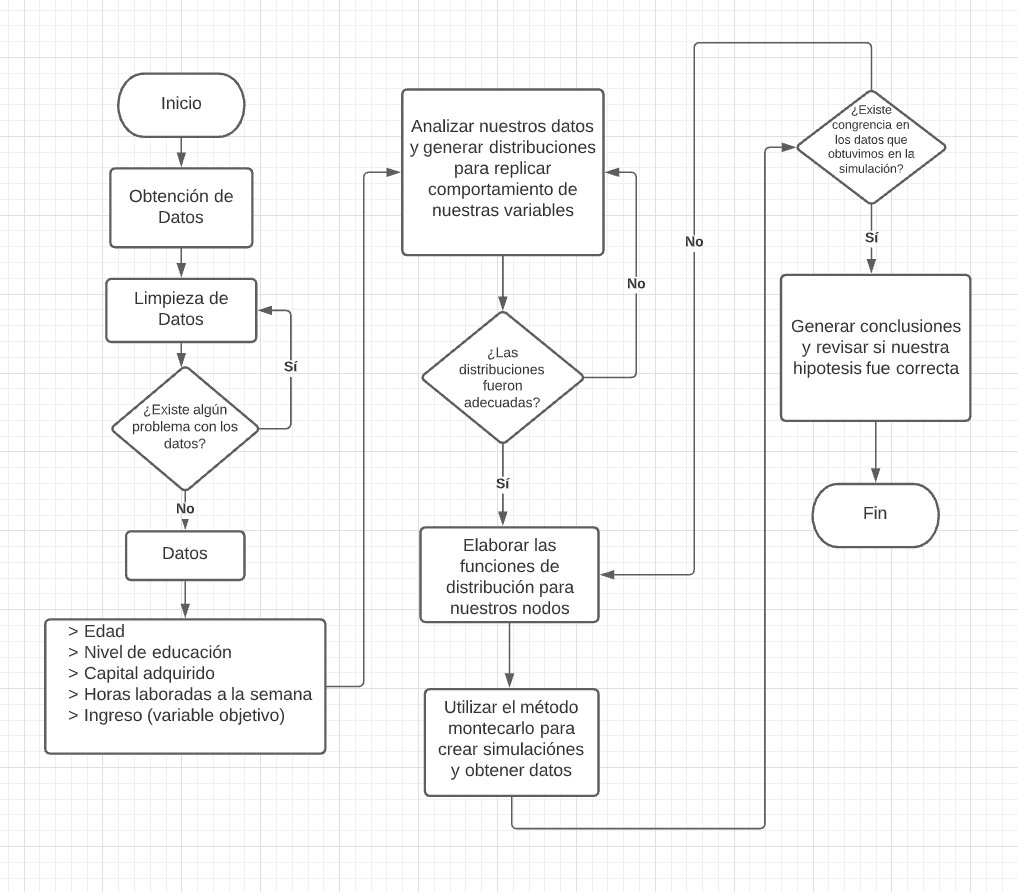

## Nodos y variables que se decidieron simular y por qué

>Para desarrollar el proyecto tomamos las siguientes variables:
    > - Edad
    > - Nivel de educación
    > - Capital adquirido
    > - Horas laboradas a la semana
    > - Ingreso (variable objetivo)

>De estas todas las variables que nos proporciona el dataset, filtramos las que no son numéricas y en la matriz de correlación que se realizó, se definieron las que más afectaban al ingreso; nuestra variable objetivo.

## Definición de hipótesis y supuestos

>Los supuestos que se dan por verdadero en nuestro proyecto son los siguientes:
    > - El ingreso define la calidad de vida de una persona.
    > - Las variables sólo son de personas adultas.
    > - Las variables que se analizarán son suficientes para determinar la condición ideal para determinar el ingreso.

>Nuestra hipótesis es que el factor que más influye en el ingreso de las personas es el nivel de educación.

## Obtención de bases de datos

> Los datos se obtuvieron de una plataforma de diferentes bases de datos llamada UCI Machine Learning Repository. La base de datos seleccionada es del censo realizado en EEUU del año 1994.

In [58]:
import numpy as np
import pandas as pd
import seaborn as sn
import statsmodels.api as sm 
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('adult.csv')
data = data[['age','educational-num','capital-gain','hours-per-week','income']].head(20001)
data

,age,educational-num,capital-gain,hours-per-week,income
0,25,7,0,40,0
1,38,9,0,50,0
2,28,12,0,40,1
3,44,10,7688,40,1
4,18,10,0,30,0
...,...,...,...,...,...
19996,21,10,0,20,0
19997,44,13,0,50,1
19998,29,13,0,40,0
19999,19,10,0,22,0


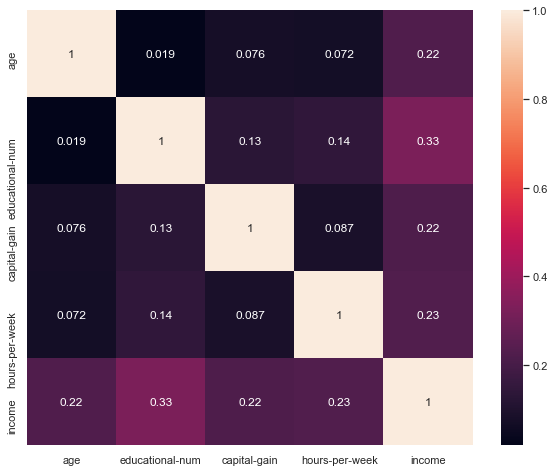

In [59]:
corrMatrix = data.corr()
sn.heatmap(corrMatrix, annot=True, linewidths=.0001)
sn.set(rc = {'figure.figsize':(10,8)})
plt.show()

### Visualización de Variables

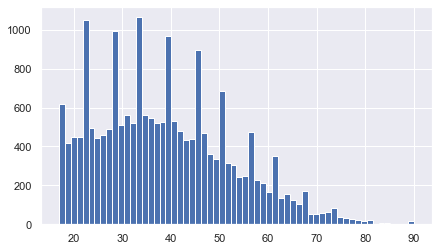

In [60]:
plt.figure(figsize=(7,4))
plt.hist(data['age'], bins = 60);

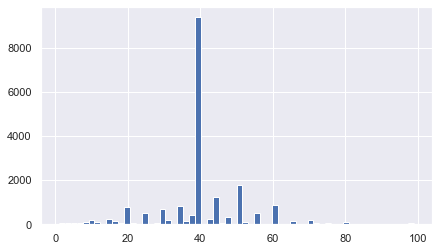

In [63]:
plt.figure(figsize=(7,4))
plt.hist(data['hours-per-week'], bins = 60);

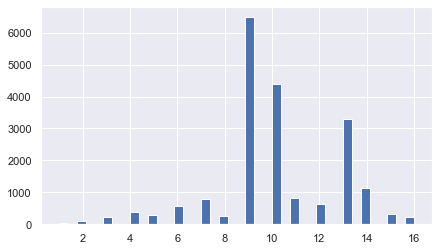

In [61]:
plt.figure(figsize=(7,4))
plt.hist(data['educational-num'], bins = 40);

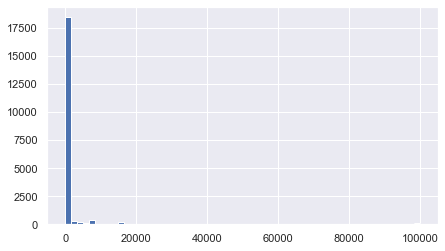

In [62]:
plt.figure(figsize=(7,4))
plt.hist(data['capital-gain'], bins = 60);

Como se puede analizar en los histogramas anteriores, no tenemos una distribución clara, por lo tanto tenemos que hacer ajustes en la información para encontrar una tendencia. Esto lo haremos a través de el método de Kernel Density Estimation.

Primero analizaremos los box plots de nuestras variables para ver si tenemos muchos outliers.

En la mayoría de los box plots tenemos varios outliers entonces implementamos el método de KDE. Para ajustar los datos aplicaremos el logaritmo.

In [125]:
def kde_sklearn(x, x_grid, bandwidth, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


def distribuciones(data):
    rv_continuas = [d_i for d_i in dir(st) if isinstance(getattr(st, d_i), getattr(st, 'rv_continuous'))]

    fig, ax = plt.subplots(1, 1, figsize=(10,7))

    error = pd.DataFrame(columns=['distribucion', 'error'])
    i = 0
    y, x, _ = ax.hist(data, bins=50, density=True)
    x = x[1:]

    for d_i in rv_continuas[20:30] + ['beta']:
        try:
            params = getattr(st, d_i).fit(data)
            data_hat = getattr(st, d_i).pdf(x, *params)
            ax.plot(x, data_hat, label=d_i)
            error.loc[i, :] = [d_i, np.mean((y - data_hat)**2)]
            i += 1
        except ValueError:
            pass

    plt.legend()
    error.set_index('distribucion', inplace=True)
    error.sort_values('error', inplace=True)
    return error

def pruebaq_q(data, dist):
    # Histograma de las variables creadas
    divisiones = 50 # Cantidad de barras en el histograma
    fig, ax = plt.subplots(2,1, figsize=(8,10))
    fig.tight_layout(pad=3.0)
    y, x, _ = ax[0].hist(data, divisiones, density=True, label='Histograma mediciones')
    params = getattr(st, dist).fit(data)
    y_hat = getattr(st, dist).pdf(x, *params)
    ax[0].plot(x, y_hat,'r--', label='Distribución ajustada')
    ax[0].set_ylabel('Probability')
    ax[0].grid()
    grap2 = st.probplot(data, dist=dist, sparams=getattr(st, dist).fit(x)[:-2], plot=ax[1], fit=True)
    ax[1].grid()
    ax[1].set_title('Usando paquete scipy')
    plt.show()
    
def red_var(data, f, t, model):
    N = 1000
    r1 = muestra_est(N*5)
    np.random.shuffle(r1)
    ct = 0
    i = 0
    var_acept = np.zeros(N)
    while ct < N:    
        r = np.random.uniform(min(data), max(data), 1)
        f_x = f(r, model)
        t_x = t(r)
        condition = r1[i] * t_x <= f_x
        if condition[0]:
            var_acept[ct] = r[0]
            ct += 1
        i+=1
    return var_acept

def pdf(x, model):
    return np.exp(model.score_samples(x.reshape(-1, 1)))

def muestra_est(n):
    u = np.random.uniform(0, 1, n)
    i = np.arange(0, n)
    return (u + i) / n

Encontramos el grid y bandwidth adecuado

#### Edad

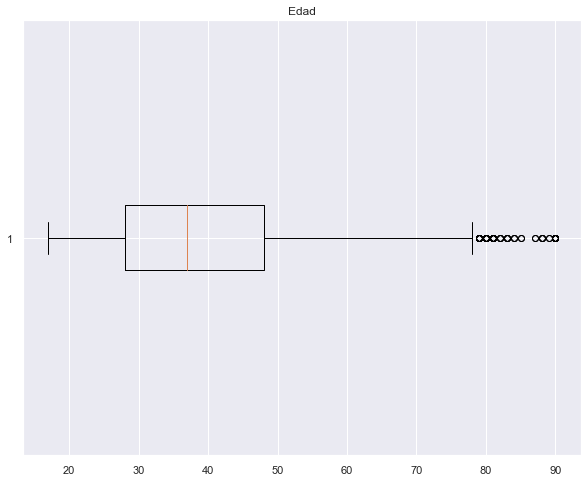

In [65]:
edad = np.array(data['age'])
plt.boxplot(edad,vert=False)
plt.title('Edad')
plt.show()

In [66]:
edad = np.log(edad[edad>0])
edad = edad[~np.isnan(edad)]
edad

array([3.21887582, 3.63758616, 3.33220451, ..., 3.36729583, 2.94443898,
       3.04452244])

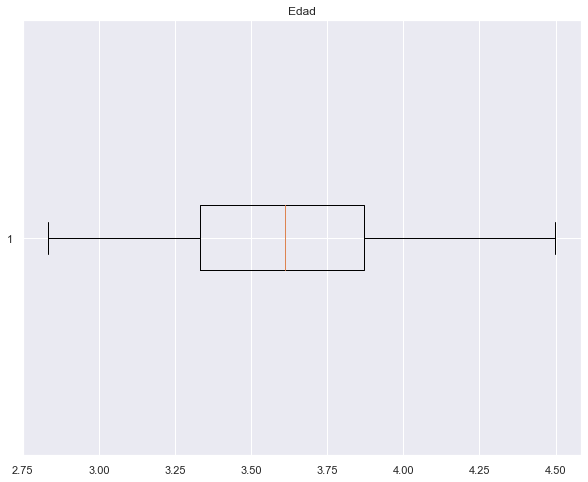

In [67]:
plt.boxplot(edad,vert=False)
plt.title('Edad')
plt.show()

In [11]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0, 1, 15)},
                    cv=15) # 15-fold cross-validation
grid.fit(edad[:, None])


GridSearchCV(cv=15, estimator=KernelDensity(),
             param_grid={'bandwidth': array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ])})

In [12]:
print(grid.best_params_)

{'bandwidth': 0.07142857142857142}


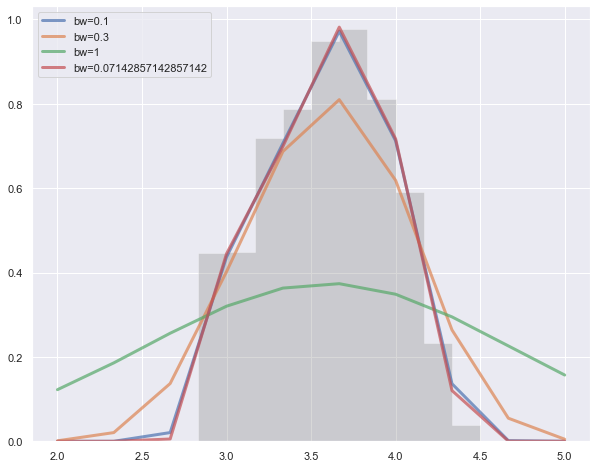

In [34]:
fig, ax = plt.subplots()
for bandwidth in [0.1, 0.3, 1, 0.07142857142857142]:
    ax.plot(np.linspace(2,5,10), kde_sklearn(edad, np.linspace(2,5,10), bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(edad, 10, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')

,error
distribucion,
exponweib,0.0683279
gausshyper,0.0739236
beta,0.0739236
frechet_l,0.0740401
foldnorm,0.0768854
frechet_r,0.0771894
f,0.0812343
fatiguelife,0.0813848
gamma,0.0830296


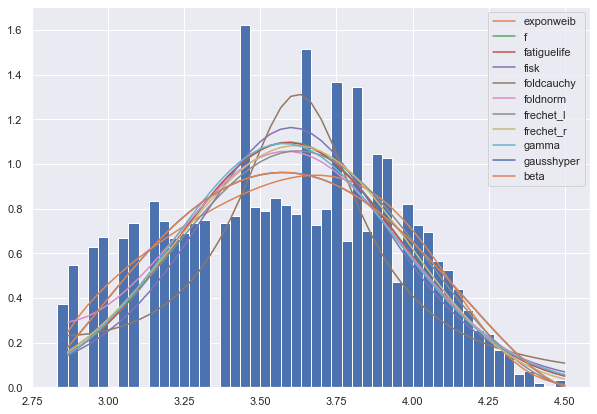

In [85]:
distribuciones(edad)

Exponweib

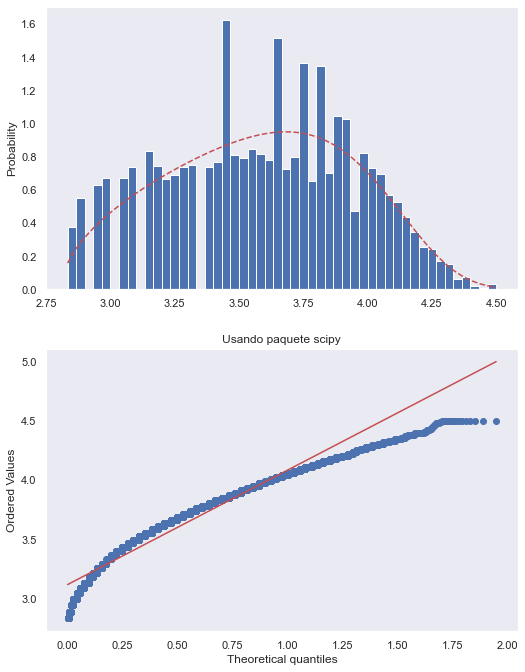

In [100]:
pruebaq_q(edad,'exponweib')

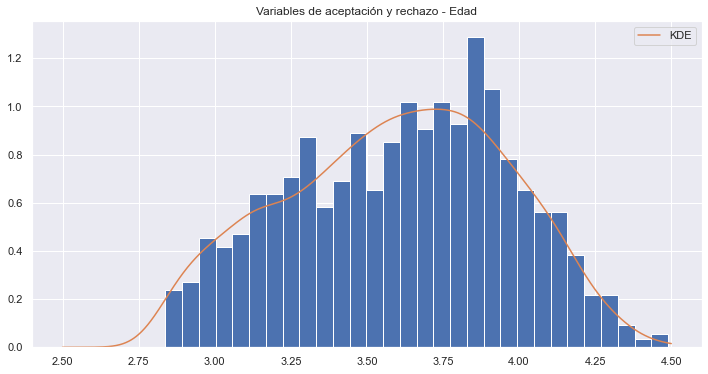

In [124]:
model = KernelDensity(bandwidth=0.07142857142857142)
model.fit(edad.reshape(-1, 1))
x_grid = np.linspace(2.5, 4.5, 1000)
pdf_edad = pdf(x_grid[:, None], model)

plt.figure(figsize=(12,6))
var_aleatorias = red_var(edad,pdf, lambda x: max(pdf_edad) * np.ones(len(x)), model)

plt.hist(var_aleatorias, 30, density=True)

plt.plot(x_grid, pdf_edad, alpha=1, label='KDE')
plt.title('Variables de aceptación y rechazo - Edad')
plt.legend()
plt.show()

## Horas de trabajo a la semana

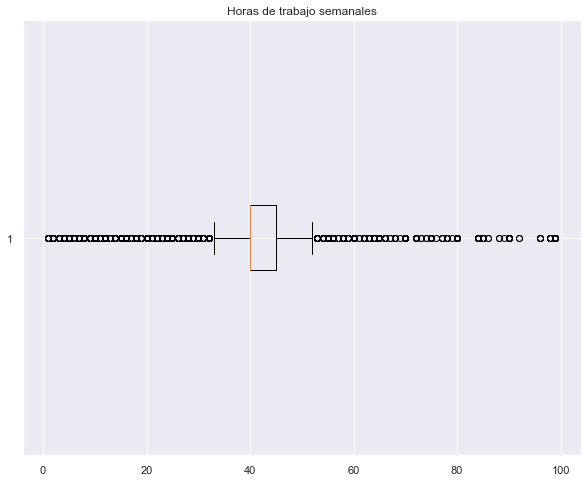

In [26]:
horas = np.array(data['hours-per-week'])
plt.boxplot(horas,vert=False)
plt.title('Horas de trabajo semanales')
plt.show()

In [27]:
horas = np.sqrt(horas[horas>0])
horas = horas[~np.isnan(horas)]
horas

array([6.32455532, 7.07106781, 6.32455532, ..., 6.32455532, 4.69041576,
       6.32455532])

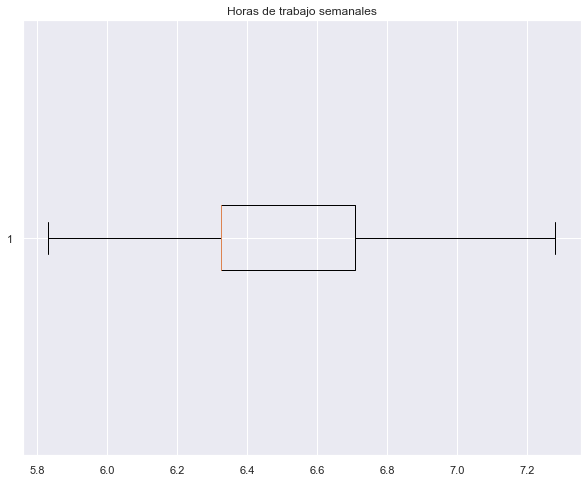

In [28]:
plt.boxplot(horas,vert=False,  showfliers=False)
plt.title('Horas de trabajo semanales')
plt.show()

In [29]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0, 1, 15)},
                    cv=15) # 15-fold cross-validation
grid.fit(horas[:, None]) 

GridSearchCV(cv=15, estimator=KernelDensity(),
             param_grid={'bandwidth': array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ])})

In [30]:
print(grid.best_params_)

{'bandwidth': 0.07142857142857142}


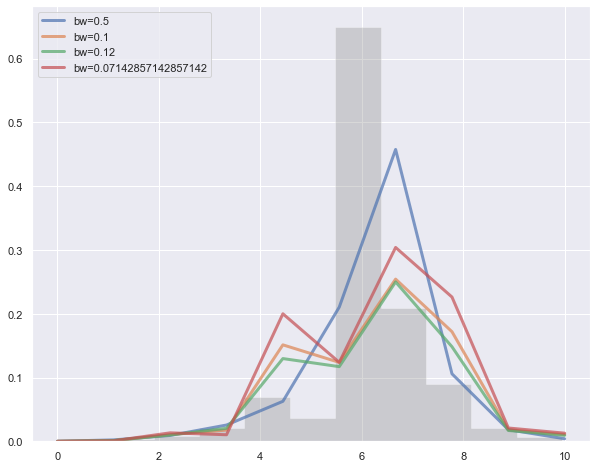

In [38]:
fig, ax = plt.subplots()
for bandwidth in [0.5, 0.1, 0.12, 0.07142857142857142]:
    ax.plot(np.linspace(0,10,10), kde_sklearn(horas, np.linspace(0,10,10), bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(horas, 10, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')

,error
distribucion,
foldcauchy,0.0423027
fisk,0.108345
beta,0.114393
frechet_r,0.11489
fatiguelife,0.115525
foldnorm,0.11555
f,0.115558
gausshyper,0.116674
gamma,0.116918


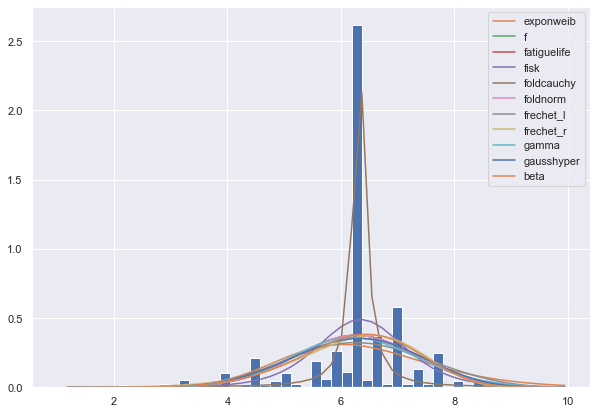

In [88]:
distribuciones(horas)

Foldcauchy

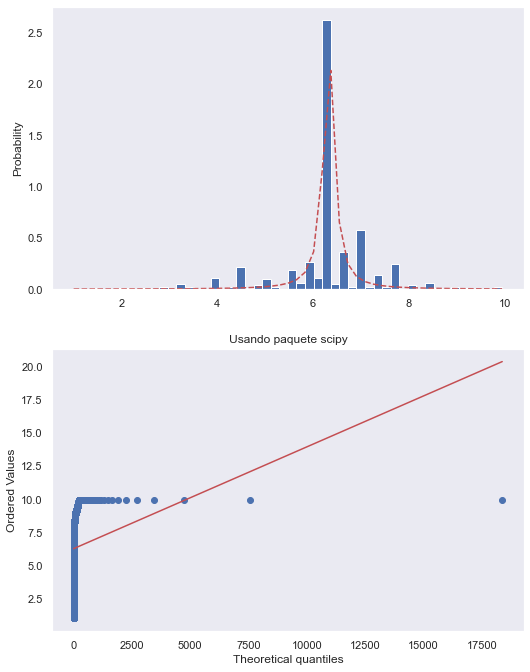

In [101]:
pruebaq_q(horas,'foldcauchy')

In [137]:
model = KernelDensity(bandwidth=0.07142857142857142)
model.fit(horas.reshape(-1, 1))
x_grid = np.linspace(0, 10, 1000)
pdf_horas = pdf(x_grid[:, None], model)

plt.figure(figsize=(12,6))
var_aleatorias = red_var(horas,pdf, lambda x: max(pdf_horas) * np.ones(len(x)), model)

plt.hist(var_aleatorias, 30, density=True)

plt.plot(x_grid, pdf_horas, alpha=1, label='KDE')
plt.title('Variables de aceptación y rechazo - Horas de trabajo')
plt.legend()
plt.show()

IndexError: index 5000 is out of bounds for axis 0 with size 5000

<Figure size 864x432 with 0 Axes>

#### Educación

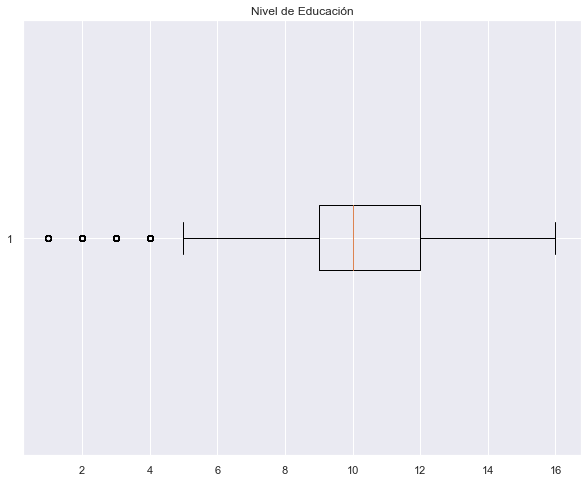

In [14]:
educacion = np.array(data['educational-num'])
plt.boxplot(educacion,vert=False)
plt.title('Nivel de Educación')
plt.show()

In [15]:
educacion = np.sqrt(educacion[educacion>0])
educacion = educacion[~np.isnan(educacion)]
educacion 

array([2.64575131, 3.        , 3.46410162, ..., 3.60555128, 3.16227766,
       3.16227766])

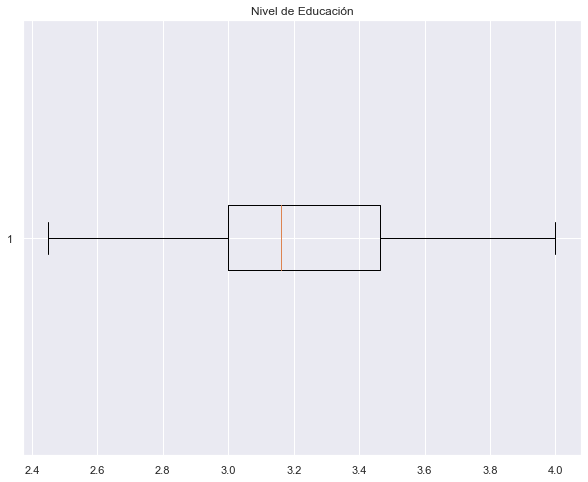

In [16]:
plt.boxplot(educacion,vert=False,  showfliers=False)
plt.title('Nivel de Educación')
plt.show()

In [17]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0, 1, 15)}, 
                    cv=15) # 15-fold cross-validation
grid.fit(educacion[:, None])

GridSearchCV(cv=15, estimator=KernelDensity(),
             param_grid={'bandwidth': array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ])})

In [18]:
print(grid.best_params_)

{'bandwidth': 0.07142857142857142}


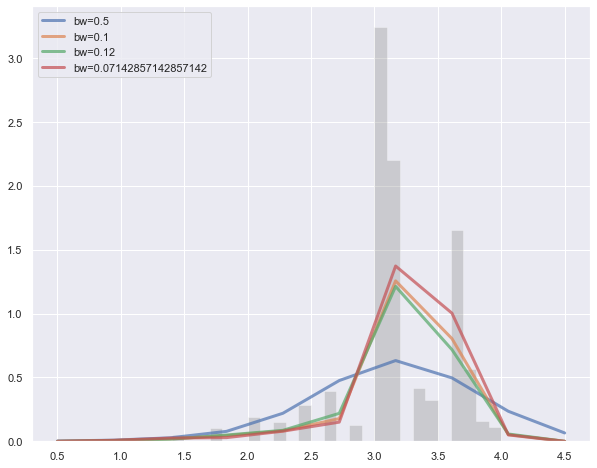

In [35]:
fig, ax = plt.subplots()
for bandwidth in [0.5, 0.1, 0.12, 0.07142857142857142]:
    ax.plot(np.linspace(0.5,4.5,10), kde_sklearn(educacion, np.linspace(0.5,4.5,10), bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(educacion, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')

,error
distribucion,
foldcauchy,0.762295
fisk,0.799852
exponweib,0.814707
fatiguelife,0.815823
f,0.815831
foldnorm,0.816574
frechet_l,0.817794
frechet_r,0.818183
beta,0.820197


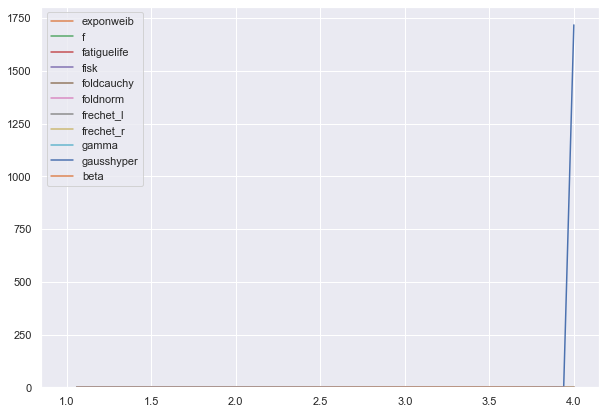

In [86]:
distribuciones(educacion)

#### Capital Adquirido

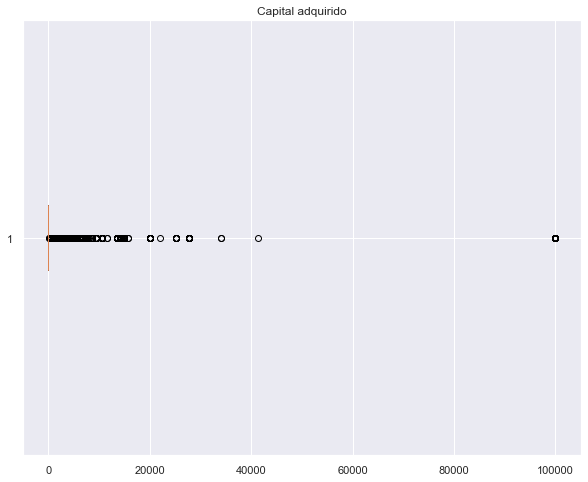

In [20]:
capital = np.array(data['capital-gain'])
plt.boxplot(capital,vert=False)
plt.title('Capital adquirido')
plt.show()

In [21]:
capital = np.log(capital[capital>0])
capital = capital[~np.isnan(capital)]
capital

array([8.94741595, 8.04012466, 8.76686182, ..., 8.10922495, 8.89535562,
       8.39298959])

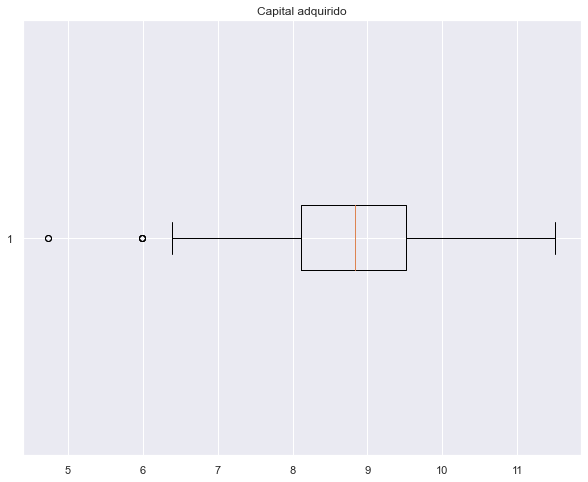

In [22]:
plt.boxplot(capital,vert=False)
plt.title('Capital adquirido')
plt.show()

In [23]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0, 1, 15)},
                    cv=15) # 15-fold cross-validation
grid.fit(capital[:, None])

GridSearchCV(cv=15, estimator=KernelDensity(),
             param_grid={'bandwidth': array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ])})

In [24]:
print(grid.best_params_)

{'bandwidth': 0.07142857142857142}


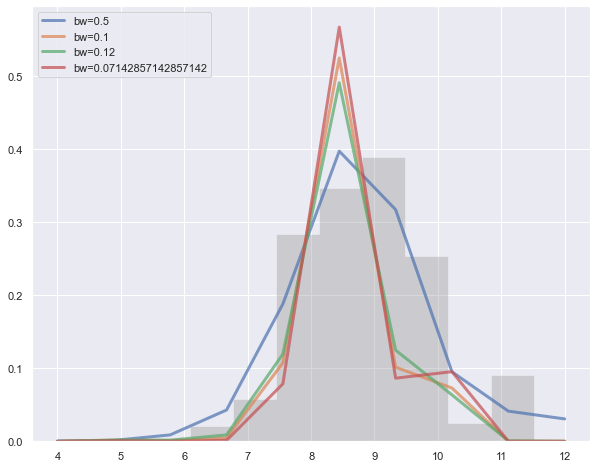

In [36]:
fig, ax = plt.subplots()
for bandwidth in [0.5, 0.1, 0.12, 0.07142857142857142]:
    ax.plot(np.linspace(4,12,10), kde_sklearn(capital, np.linspace(4,12,10), bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(capital, 10, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')

,error
distribucion,
fisk,0.0357138
exponweib,0.0368218
f,0.0369566
fatiguelife,0.0369857
beta,0.0370001
gamma,0.0370152
foldnorm,0.0373263
foldcauchy,0.0387123
gausshyper,0.0995608


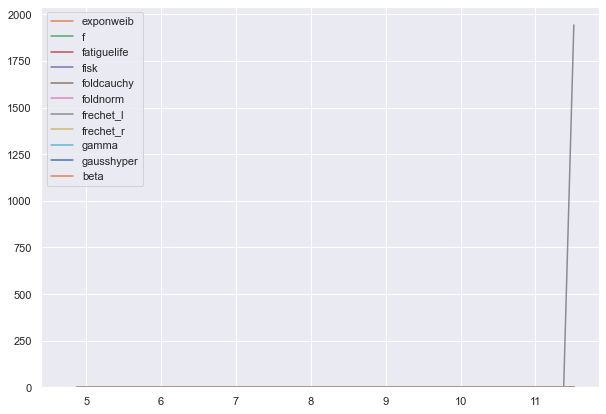

In [87]:
distribuciones(capital)

### Visualización de resultados de simulación

### Conclusiones

### Referencias

T.T.B. (2021, 4 agosto). Medical Insurance Premium Prediction. Recuperado 9 de octubre de 2021, de https://www.kaggle.com/tejashvi14/medical-insurance-premium-prediction